**If you're using google colab run the next cell**

In [ ]:
!pip install gym==0.26.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 35.4 MB/s eta 0:00:00


Exception ignored in: <function VideoRecorder.__del__ at 0x7f87149b0160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py", line 269, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py", line 234, in close
    os.remove(self.path)
FileNotFoundError: [Errno 2] No such file or directory: 'video/lake.mp4'
Exception ignored in: <function VideoRecorder.__del__ at 0x7f87149b0160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py", line 269, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py", line 234, in close
    os.remove(self.path)
FileNotFoundError: [Errno 2] No such file or directory: 'video/lake.mp4'


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827631 sha256=03411b7b3f75d6664142b30f6d6095c33e57dd6cc2e4c7608bc1e4275a63890b
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
!conda install matplotlib -y

/bin/bash: conda: command not found


# Helpers

In [1]:
import matplotlib
import time
import math
import copy
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from collections import defaultdict

In [39]:
# Function to evaluate a policy in an environment
def count_rewards_of_policy(env, policy, num_episodes=1000):
    rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = policy(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)
    return sum(rewards) / num_episodes

In [25]:
def _policy(observation, value_function, size=5):
  action = indices_of_max_values(get_neighbor(value_function, observation, size=size))
  #action is value indicate the arrow position.  return a list for the direction
  return action

# this function return the indices of the max value
def indices_of_max_values(arr):
    max_value = np.max(arr)
    indices = np.where(arr == max_value)[0]
    return indices

 # the use of this function is to give you the sourroding elements to each state.
 # In case something was not clear I advice you to use print function and see each step output.
def get_neighbor(array_2d, state, size=5):

  # create a mapping table
  states = np.array(range(size*size)).reshape(size, size)
  # find row and col of each state, you can use this or day1 method
  row = np.where(states == state)[0][0]
  col =  np.where(states == state)[1][0]

  # Get the neighboring elements
  top = array_2d[row - 1, col] if row - 1 >= 0 else 0  # element above
  bottom = array_2d[row + 1, col] if row + 1 < array_2d.shape[0] else 0  # element below
  left = array_2d[row, col - 1] if col - 1 >= 0 else 0  # element to the left
  right = array_2d[row, col + 1] if col + 1 < array_2d.shape[1] else 0  # element to the right

  return right, bottom, left, top

def plot_policy_matrix(P: dict, S:np.array, goal_coords: list = [], img_width: int = 5, img_height: int = 5, title: str = None) -> None:
    """
    Plots the policy matrix out of the dictionary provided; The dictionary values are used to draw the arrows
    """
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    for y in range(height):
        for x in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))

            else:
                # Adding the arrows to the plot
                if 'up' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                if 'down' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                if 'left' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                if 'right' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)


    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)


def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> Tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y



# helper functions
def test_policy(policy, valueFunction, size=5):
  my_dict = {key: None for key in range(25)}
  
  for i in range (25):
    action = policy(i, valueFunction, size=size)
    if (len(action) == 4):
      my_dict[i] = {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}
    elif ((len(action) == 3)):
      dir = num2text(action)
      my_dict[i] = {dir[0]: 0.333, dir[1]: 0.333, dir[2]: 0.333}
    elif(len(action) == 2):
      dir = num2text(action)
      my_dict[i] = {dir[0]: 0.5,dir[1]: 0.5}
    else:
      dir = num2text(action)
      my_dict[i] = {dir[0]:1}

  return my_dict

# helper functions
def test_policy2(policy, valueFunction, size=4):
  my_dict = {key: None for key in range(size*size)}

  def custom_mapping(x):
    if x == 0:
        return 2
    elif x == 1:
        return 1
    elif x == 2:
        return 0
    else:
        return x
    
  for i in range (size*size):
    action = policy[i]
    action = [custom_mapping(action)]
    if (len(action) == 4):
      my_dict[i] = {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}
    elif ((len(action) == 3)):
      dir = num2text(action)
      my_dict[i] = {dir[0]: 0.333, dir[1]: 0.333, dir[2]: 0.333}
    elif(len(action) == 2):
      dir = num2text(action)
      my_dict[i] = {dir[0]: 0.5, dir[1]: 0.5}
    else:
      dir = num2text(action)
      my_dict[i] = {dir[0]:1}

  return my_dict


def num2text(action):
  text = list()
  for i in action:
    if (i == 0):
      text.append("right")
    elif(i==1):
      text.append("down")
    elif(i==2):
      text.append("left")
    else :
      text.append("up")
  return text


# Day 4: Value Function, and Finding the Optimal Policy Using Value Itteration


To solve a reinforcement learning task, we aim to find a policy that maximizes the cumulative reward in the long run. In the case of finite Markov Decision Processes (MDPs), we can precisely define an optimal policy based on the concept of value functions. Value functions provide a way to compare and order policies.

We say that one policy is better than or equal to another policy if, for all states, the expected return (cumulative reward) under the first policy is greater than or equal to the expected return under the second policy. In other words, policy A is better than or equal to policy B if, for all states, the expected return of A is greater than or equal to the expected return of B.

There is always at least one policy that is better than or equal to all other policies. This policy is known as the optimal policy. While there may be multiple optimal policies, they all share the same state-value function, denoted as V*. The optimal state-value function represents the expected return under the optimal policy for each state.

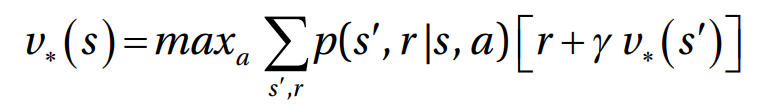

In summary, the goal is to find an optimal policy that maximizes the expected return, and all optimal policies have the same state-value function V*.



to read more about finding the optimal value function: [Optimal Vlaue Function](http://incompleteideas.net/book/ebook/node35.html)

# Value Itteration Algorithm


Value iteration is an algorithm used for solving Markov decision processes (MDPs) to find the optimal value function and policy. It involves iteratively updating the values of states based on the maximum expected future rewards achievable from each state. The algorithm starts with an initial value function and then repeatedly applies two steps: (1) computing the value of each state as the maximum expected future reward by considering all possible actions, and (2) updating the policy by selecting the action that maximizes the expected future reward for each state. Value iteration continues these steps until the values converge to their optimal values, indicating the optimal policy has been found. Unlike policy iteration, value iteration does not separate the policy evaluation and policy improvement steps, but rather combines them in a single process.

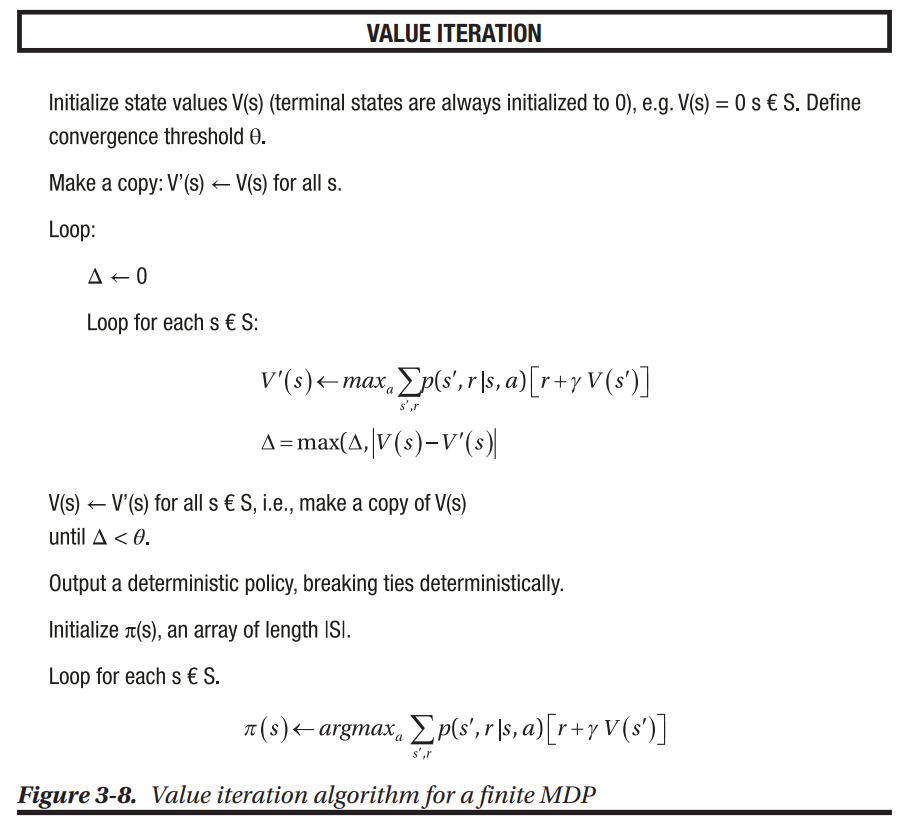

## Value iteration from RL saton book
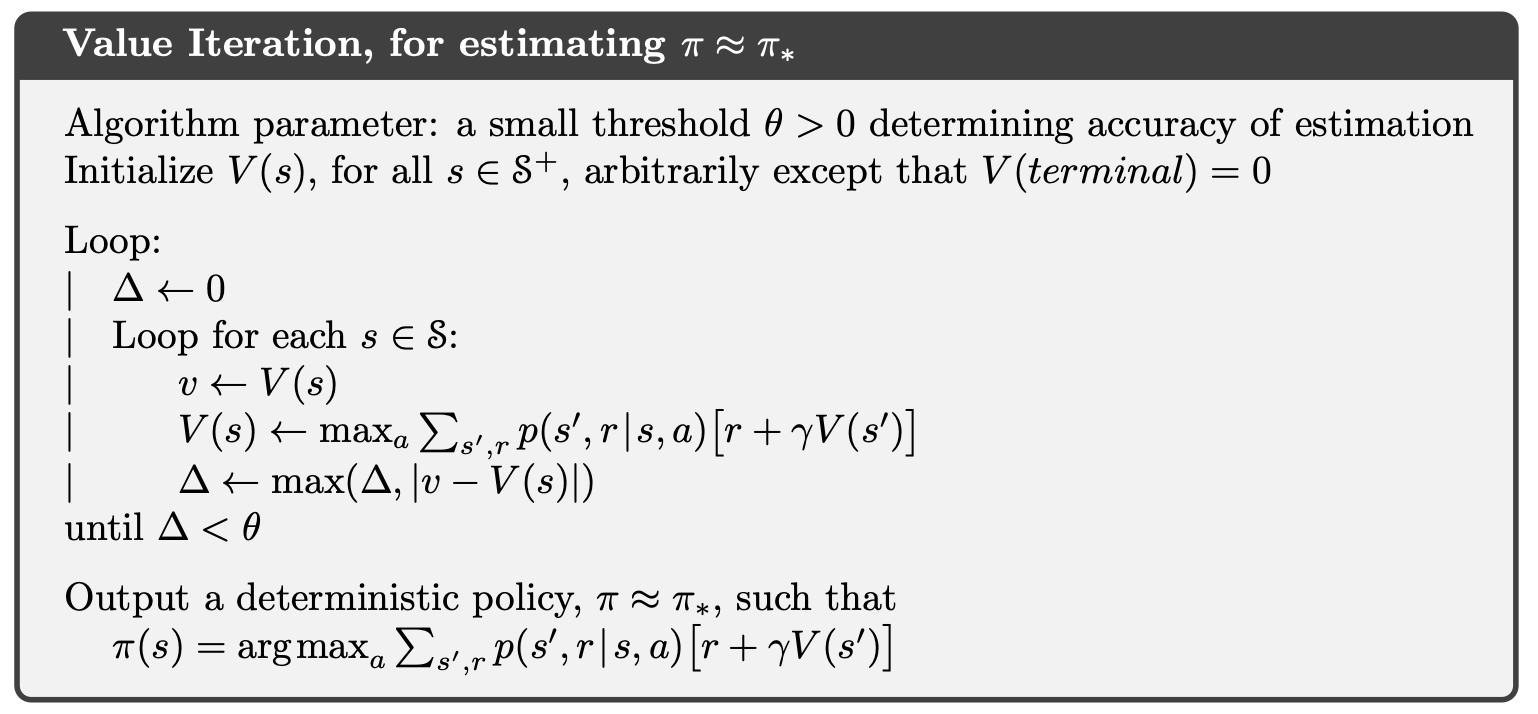

Note that an important it feature of the value itteration method is that it needs only Bellman Optimality equations to find the optimal policy.

# Gridwold Example

We will start with the gridworld example explained in class. In this problem you will be using the value itteration method to find the optimal value function, and then to use it and find the optimnal policy. The value function given bellow if for the none-determinstic case assuming each action has probablity of 1/4 to happen.

 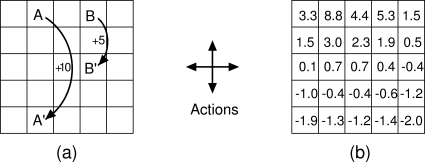

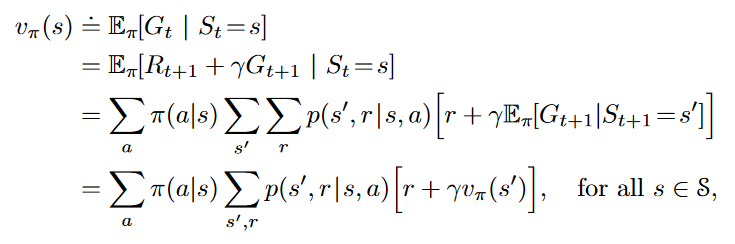

The author of the [book](http://incompleteideas.net/book/the-book-2nd.html) had to solve for 25 equations with 25 unknows to obtain these values. Following the same procedure, we can obtain the optimum value function by solving the Bellman optimality equation for the determinstic case:

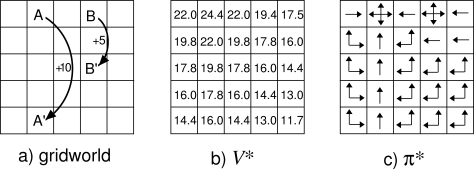

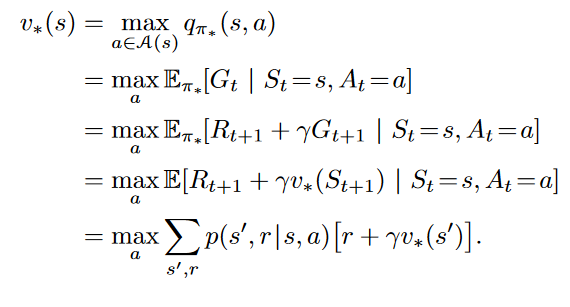

In this notebook you are required to find V* using the value itteration method, and to write a policy that utilze the optimum value function to reach the goal (optimum policy).

The class GridworldEnvironment is used to evaluate the policy only.

In [47]:
class GridworldEnvironment(gym.Env):

    action_space = spaces.Discrete(4)
    observation_space = spaces.Discrete(25)

    def __init__(self):

        self.grid_world = np.zeros((5, 5))
        self.grid_world[0, 1] = 10  # Position A
        self.grid_world[0, 3] = 5   # Position B
        self.states = [(i,j) for i in range(5) for j in range(5)]
        self.P =  defaultdict(dict)
        
        self.current_state = (0, 0)
        
        self._mdp_duration = 10000
        self._current_step = 0

        for state in self.states:
            self.P[state] = dict()
            for action in range(self.action_space.n):
                self.current_state = state  # Set the current state to the current position
                next_state, reward, done, _, _ = self.step(self.num2text(action))
                self.P[state][action] = [(1, next_state, reward, False)]
        self.current_state = (0, 0)
        self._current_step = 0



    def step(self, action):
        self._current_step += 1
        i, j = self.current_state
        action  = action [0]
        if action == 'up':
            next_state = (i - 1, j)
        elif action == 'down':
            next_state = (i + 1, j)
        elif action == 'left':
            next_state = (i, j - 1)
        elif action == 'right':
            next_state = (i, j + 1)
        else:
            raise ValueError()

        if self.current_state == (0, 1):
            next_state = (4, 1)  # Transition to position A
            reward = 10

        elif self.current_state == (0, 3):
            next_state = (2, 3)  # Transition to position B
            reward = 5

        elif next_state[0] < 0 or next_state[0] >= 5 or next_state[1] < 0 or next_state[1] >= 5:
            # Stay at the same position if action moves outside the grid
            next_state = self.current_state
            reward = -1
        else:
            reward = 0

        self.current_state = next_state
        return next_state, reward, self._current_step == self._mdp_duration, False, _


    def num2text(self,action):

        text = list()
        if (action == 0):
            text.append("right")
        elif(action ==1):
            text.append("down")
        elif(action ==2):
            text.append("left")
        else:
            text.append("up")
        return text

     #(probality of taking action, next state reached, reward, goal_reached)

In [5]:
env = GridworldEnvironment()

In [6]:
env.P

defaultdict(dict,
            {(0, 0): {0: [(1, (0, 1), 0, False)],
              1: [(1, (1, 0), 0, False)],
              2: [(1, (0, 0), -1, False)],
              3: [(1, (0, 0), -1, False)]},
             (0, 1): {0: [(1, (4, 1), 10, False)],
              1: [(1, (4, 1), 10, False)],
              2: [(1, (4, 1), 10, False)],
              3: [(1, (4, 1), 10, False)]},
             (0, 2): {0: [(1, (0, 3), 0, False)],
              1: [(1, (1, 2), 0, False)],
              2: [(1, (0, 1), 0, False)],
              3: [(1, (0, 2), -1, False)]},
             (0, 3): {0: [(1, (2, 3), 5, False)],
              1: [(1, (2, 3), 5, False)],
              2: [(1, (2, 3), 5, False)],
              3: [(1, (2, 3), 5, False)]},
             (0, 4): {0: [(1, (0, 4), -1, False)],
              1: [(1, (1, 4), 0, False)],
              2: [(1, (0, 3), 0, False)],
              3: [(1, (0, 4), -1, False)]},
             (1, 0): {0: [(1, (1, 1), 0, False)],
              1: [(1, (2, 0), 0, False

## Policy Iteration

In [68]:
def policy_iteration(env, all_possible_states, max_iterations=1000, gamma=0.9):
    policy = {state: env.action_space.sample() for state in all_possible_states}
    state_values = {state: 0 for state in all_possible_states}
    total_count = 0
    for i in range(max_iterations):
        # Policy Evaluation
        state_values, count = evaluate_policy(env, all_possible_states, policy, state_values, gamma)
        total_count += (i+1) * count
        # Policy Improvement
        policy_stable = True
        for state in all_possible_states:
            old_action = policy[state]
            action_values = []

            for action in range(env.action_space.n):
                q_value = 0

                for prob, next_state, reward, _ in env.P[state][action]:
                    q_value += prob * (reward + gamma * state_values[next_state])

                action_values.append(q_value)

            best_action = np.argmax(action_values)
            policy[state] = best_action

            if old_action != best_action:
                policy_stable = False
        
        if policy_stable:
            print(f"It took {total_count} iterations to find the policy")
            break

    return policy, state_values

def evaluate_policy(env, all_possible_states, policy, state_values, gamma):
    new_state_values = state_values.copy()
    count = 0
    while True:
        delta = 0

        for state in all_possible_states:
            action = policy[state]
            q_value = 0

            for prob, next_state, reward, _ in env.P[state][action]:
                q_value += prob * (reward + gamma * state_values[next_state])

            new_state_values[state] = q_value
            delta = max(delta, abs(new_state_values[state] - state_values[state]))
            
        count += 1
        if delta < 1e-4:
            print(f"evaluate policy did {count} iterations")
            break
        
        state_values = new_state_values.copy()

    return state_values, count


In [69]:
p, value_function = policy_iteration(env, env.states, 1000)

evaluate policy did 89 iterations
evaluate policy did 102 iterations
evaluate policy did 4 iterations
evaluate policy did 2 iterations
evaluate policy did 2 iterations
evaluate policy did 2 iterations
evaluate policy did 98 iterations
evaluate policy did 4 iterations
evaluate policy did 1 iterations
It took 1062 iterations to find the policy


In [70]:
value_function

{(0, 0): 21.977351538520185,
 (0, 1): 24.41927948724465,
 (0, 2): 21.977351538520185,
 (0, 3): 19.41927948724465,
 (0, 4): 17.477351538520185,
 (1, 0): 19.779616384668167,
 (1, 1): 21.977351538520185,
 (1, 2): 19.779616384668167,
 (1, 3): 17.801654744834714,
 (1, 4): 16.021421654012542,
 (2, 0): 17.801654744834714,
 (2, 1): 19.779616384668167,
 (2, 2): 17.801654744834714,
 (2, 3): 16.021421654012542,
 (2, 4): 14.41927948724465,
 (3, 0): 16.021421654012542,
 (3, 1): 17.801654744834714,
 (3, 2): 16.021421654012542,
 (3, 3): 14.41927948724465,
 (3, 4): 12.977351538520185,
 (4, 0): 14.41927948724465,
 (4, 1): 16.021421654012542,
 (4, 2): 14.41927948724465,
 (4, 3): 12.977351538520185,
 (4, 4): 11.679616384668167}

## Value Iteration

In [71]:
def value_iteration(env, all_possible_states, max_iterations=1000, gamma=0.9):
    state_values = {state: 0 for state in all_possible_states}
    new_state_values = state_values.copy()

    for i in range(max_iterations):
        delta = 0
        for state in all_possible_states:
            action_values = []

            for action in range(env.action_space.n):
                ...

                for prob, next_state, reward, done in env.P[state][action]:
                    pass

                action_values.append(...)

            best_action_value = max(...)
            new_state_values[state] = best_action_value

            delta = max(delta, abs(...))

        if delta < 1e-4:
            print(f"It took {i+1} iterations to find the policy")
            break

        state_values = new_state_values.copy()

    return state_values


In [72]:
value_function = value_iteration(env, env.states, 1000)
value_function

It took 111 iterations to find the policy


{(0, 0): 21.977281745295162,
 (0, 1): 24.419201939216848,
 (0, 2): 21.977281745295162,
 (0, 3): 19.419201939216848,
 (0, 4): 17.477281745295162,
 (1, 0): 19.779553570765646,
 (1, 1): 21.977281745295162,
 (1, 2): 19.779553570765646,
 (1, 3): 17.801598213689083,
 (1, 4): 16.021438392320174,
 (2, 0): 17.801598213689083,
 (2, 1): 19.779553570765646,
 (2, 2): 17.801598213689083,
 (2, 3): 16.021438392320174,
 (2, 4): 14.41920193921685,
 (3, 0): 16.021438392320174,
 (3, 1): 17.801598213689083,
 (3, 2): 16.021438392320174,
 (3, 3): 14.41920193921685,
 (3, 4): 12.977281745295164,
 (4, 0): 14.41920193921685,
 (4, 1): 16.021438392320174,
 (4, 2): 14.41920193921685,
 (4, 3): 12.977281745295164,
 (4, 4): 11.679553570765648}

### Visualization
Once you find the value function, you can find the optimal policy by running the following two cells of code.  <br>
The answer should be the same as the one obtained in day 2.

In [73]:
value_function_2d = np.zeros((5, 5))
for key, value in value_function.items():
    value_function_2d[key[0], key[1]] = value

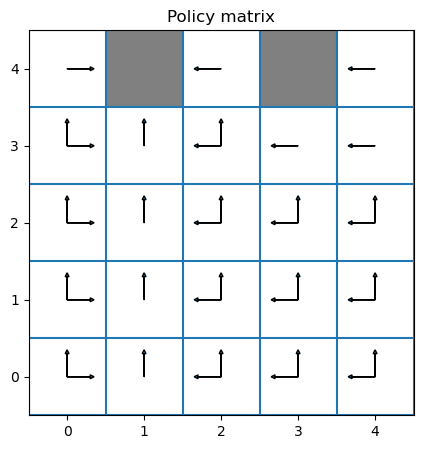

In [74]:
S = np.arange(0, 25).reshape(5, 5)
P =  test_policy(_policy, value_function_2d)
goal_coords = [(0,1),(0,3)]
# Drawing a plot for the policy matrix with arrows; In one cell there can be the maximum of 4 arrows each indicating the action an agent can take
plot_policy_matrix(P, S, goal_coords, title='Policy matrix')

# Frozen Lake Example

Frozen lake is a toy text environment involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake.

We can also set the lake to be slippery so that the agent does not always move in the intended direction. \but here, we will only look at the non-slippery case. But you are welcome to try the slippery one.

You can read more about the environment [lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

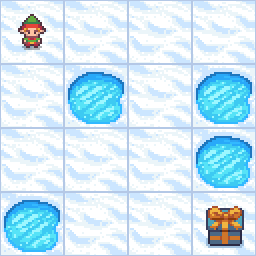

In [75]:
# For visualization
import gym
import numpy as np
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os
import random
os.environ['SDL_VIDEODRIVER']='dummy'
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name, env, policy, max_steps=10000):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, _ = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = policy[state]
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        print(f"state: {state}, action: {action}", next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

## Creating the environment

In [93]:
env_2d = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

In [86]:
env_2d.P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:

## Policy Iteration

In [91]:
p, value_function = policy_iteration(env_2d, list(range(16)), 1000)

evaluate policy did 24 iterations
evaluate policy did 34 iterations
evaluate policy did 16 iterations
It took 140 iterations to find the policy


## value itteration Alogrithm

In [92]:
value_function = value_iteration(env_2d, all_possible_states=list(range(16)))
value_function

It took 44 iterations to find the policy


{0: 0.06816140083958722,
 1: 0.06079673145467859,
 2: 0.07395924794405573,
 3: 0.055312563929100625,
 4: 0.09119094854328333,
 5: 0.0,
 6: 0.11196558957724005,
 7: 0.0,
 8: 0.1448987534241835,
 9: 0.2471341985684918,
 10: 0.2993622160201679,
 11: 0.0,
 12: 0.0,
 13: 0.37967376065110875,
 14: 0.6388827309050886,
 15: 0.0}

In [79]:
def get_neighbor_actions(state, grid_size):
    row, col = divmod(state, grid_size)
    actions = []

    if col > 0:
        actions.append(0)  # Left
    if row < grid_size - 1:
        actions.append(1)  # Down
    if col < grid_size - 1:
        actions.append(2)  # Right
    if row > 0:
        actions.append(3)  # Up

    return actions

def extract_policy(value_function, grid_size):
    policy = {}

    for state, value in value_function.items():
        actions = get_neighbor_actions(state, grid_size=grid_size)
        max_value = max(value_function[a] for a in actions)
        best_actions = [a for a in actions if value_function[a] == max_value]
        policy[state] = np.random.choice(best_actions)

    return policy

In [80]:
value_function_2d

array([[21.97728175, 24.41920194, 21.97728175, 19.41920194, 17.47728175],
       [19.77955357, 21.97728175, 19.77955357, 17.80159821, 16.02143839],
       [17.80159821, 19.77955357, 17.80159821, 16.02143839, 14.41920194],
       [16.02143839, 17.80159821, 16.02143839, 14.41920194, 12.97728175],
       [14.41920194, 16.02143839, 14.41920194, 12.97728175, 11.67955357]])

In [81]:
p = extract_policy(value_function, 4)

In [82]:
p

{0: 2,
 1: 2,
 2: 2,
 3: 1,
 4: 2,
 5: 2,
 6: 2,
 7: 3,
 8: 2,
 9: 2,
 10: 2,
 11: 3,
 12: 2,
 13: 2,
 14: 2,
 15: 3}

## Visualization

These functions are to see the optimal policy (same as the code you saw in day 2)

In [36]:
value_function_2d = np.zeros((4, 4))
for key, value in value_function.items():
    row = key // 4
    col = key % 4
    value_function_2d[row, col] = value

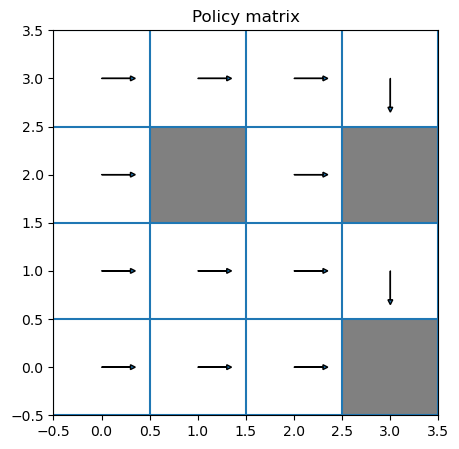

In [37]:
S = np.arange(0, 16).reshape(4, 4)
P =  test_policy2(p, value_function_2d, size=4)
goal_coords = [(3, 3), (1, 1), (1, 3)]
# Drawing a plot for the policy matrix with arrows; In one cell there can be the maximum of 4 arrows each indicating the action an agent can take
plot_policy_matrix(P, S, goal_coords, title='Policy matrix')

In [45]:
show_video_of_model("lake", env_2d, p, max_steps=10000)

/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Exception ignored in: <function VideoRecorder.__del__ at 0x10614bf60>
Traceback (most recent call last):
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/gym/wrappers/monitoring/video_recorder.py", line 178, in __del__
    self.close()
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/gym/wrappers/monitoring/video_recorder.py", line 152, in close
    raise error.DependencyNotInstalled(
gym.error.DependencyNotInstalled: MoviePy is not installed, run `pip install moviepy`


state: 0, action: 2 1 0.0 False
state: 1, action: 2 2 0.0 False
state: 2, action: 2 3 0.0 False
state: 3, action: 1 7 0.0 True


Exception ignored in: <function VideoRecorder.__del__ at 0x10614bf60>
Traceback (most recent call last):
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/gym/wrappers/monitoring/video_recorder.py", line 178, in __del__
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/gym/wrappers/monitoring/video_recorder.py", line 158, in close
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/decorator.py", line 232, in fun
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/moviepy/decorators.py", line 54, in requires_duration
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/decorator.py", line 232, in fun
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/moviepy/decorators.py", line 135, in use_clip_fps_by_default
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/python3.11/site-packages/decorator.py", line 232, in fun
  File "/Users/aljahdmk/miniconda3/envs/RL/lib/pytho

Moviepy - Building video video/lake.mp4.
Moviepy - Writing video video/lake.mp4

Moviepy - Building video video/lake.mp4.
Moviepy - Writing video video/lake.mp4

Moviepy - Building video video/lake.mp4.
Moviepy - Writing video video/lake.mp4



TypeError: must be real number, not NoneType

In [46]:
show_video("lake")

Could not find video
